##  Análisis Exploratorio de Datos (EDA) de Ventas

Notebook: H2.ipynb | Celda: 4 | Propósito: Explorar la distribución, tendencias y rendimiento de las ventas.

 Preparación y Preprocesamiento de Datos

 Datos cargados correctamente desde los archivos CSV.
 Preparando datos...
 Preparación de datos completada.

---  MÉTRICAS DESCRIPTIVAS GLOBALES (Total Ventas) ---
 Ventas Totales: 21,653,251,303.33
μ Media de la Venta: 17,341.75
~ Mediana de la Venta: 13,961.02
σ Desviación Estándar: 39,180.14

---  GENERACIÓN DE VISUALIZACIONES (Gráficos) ---


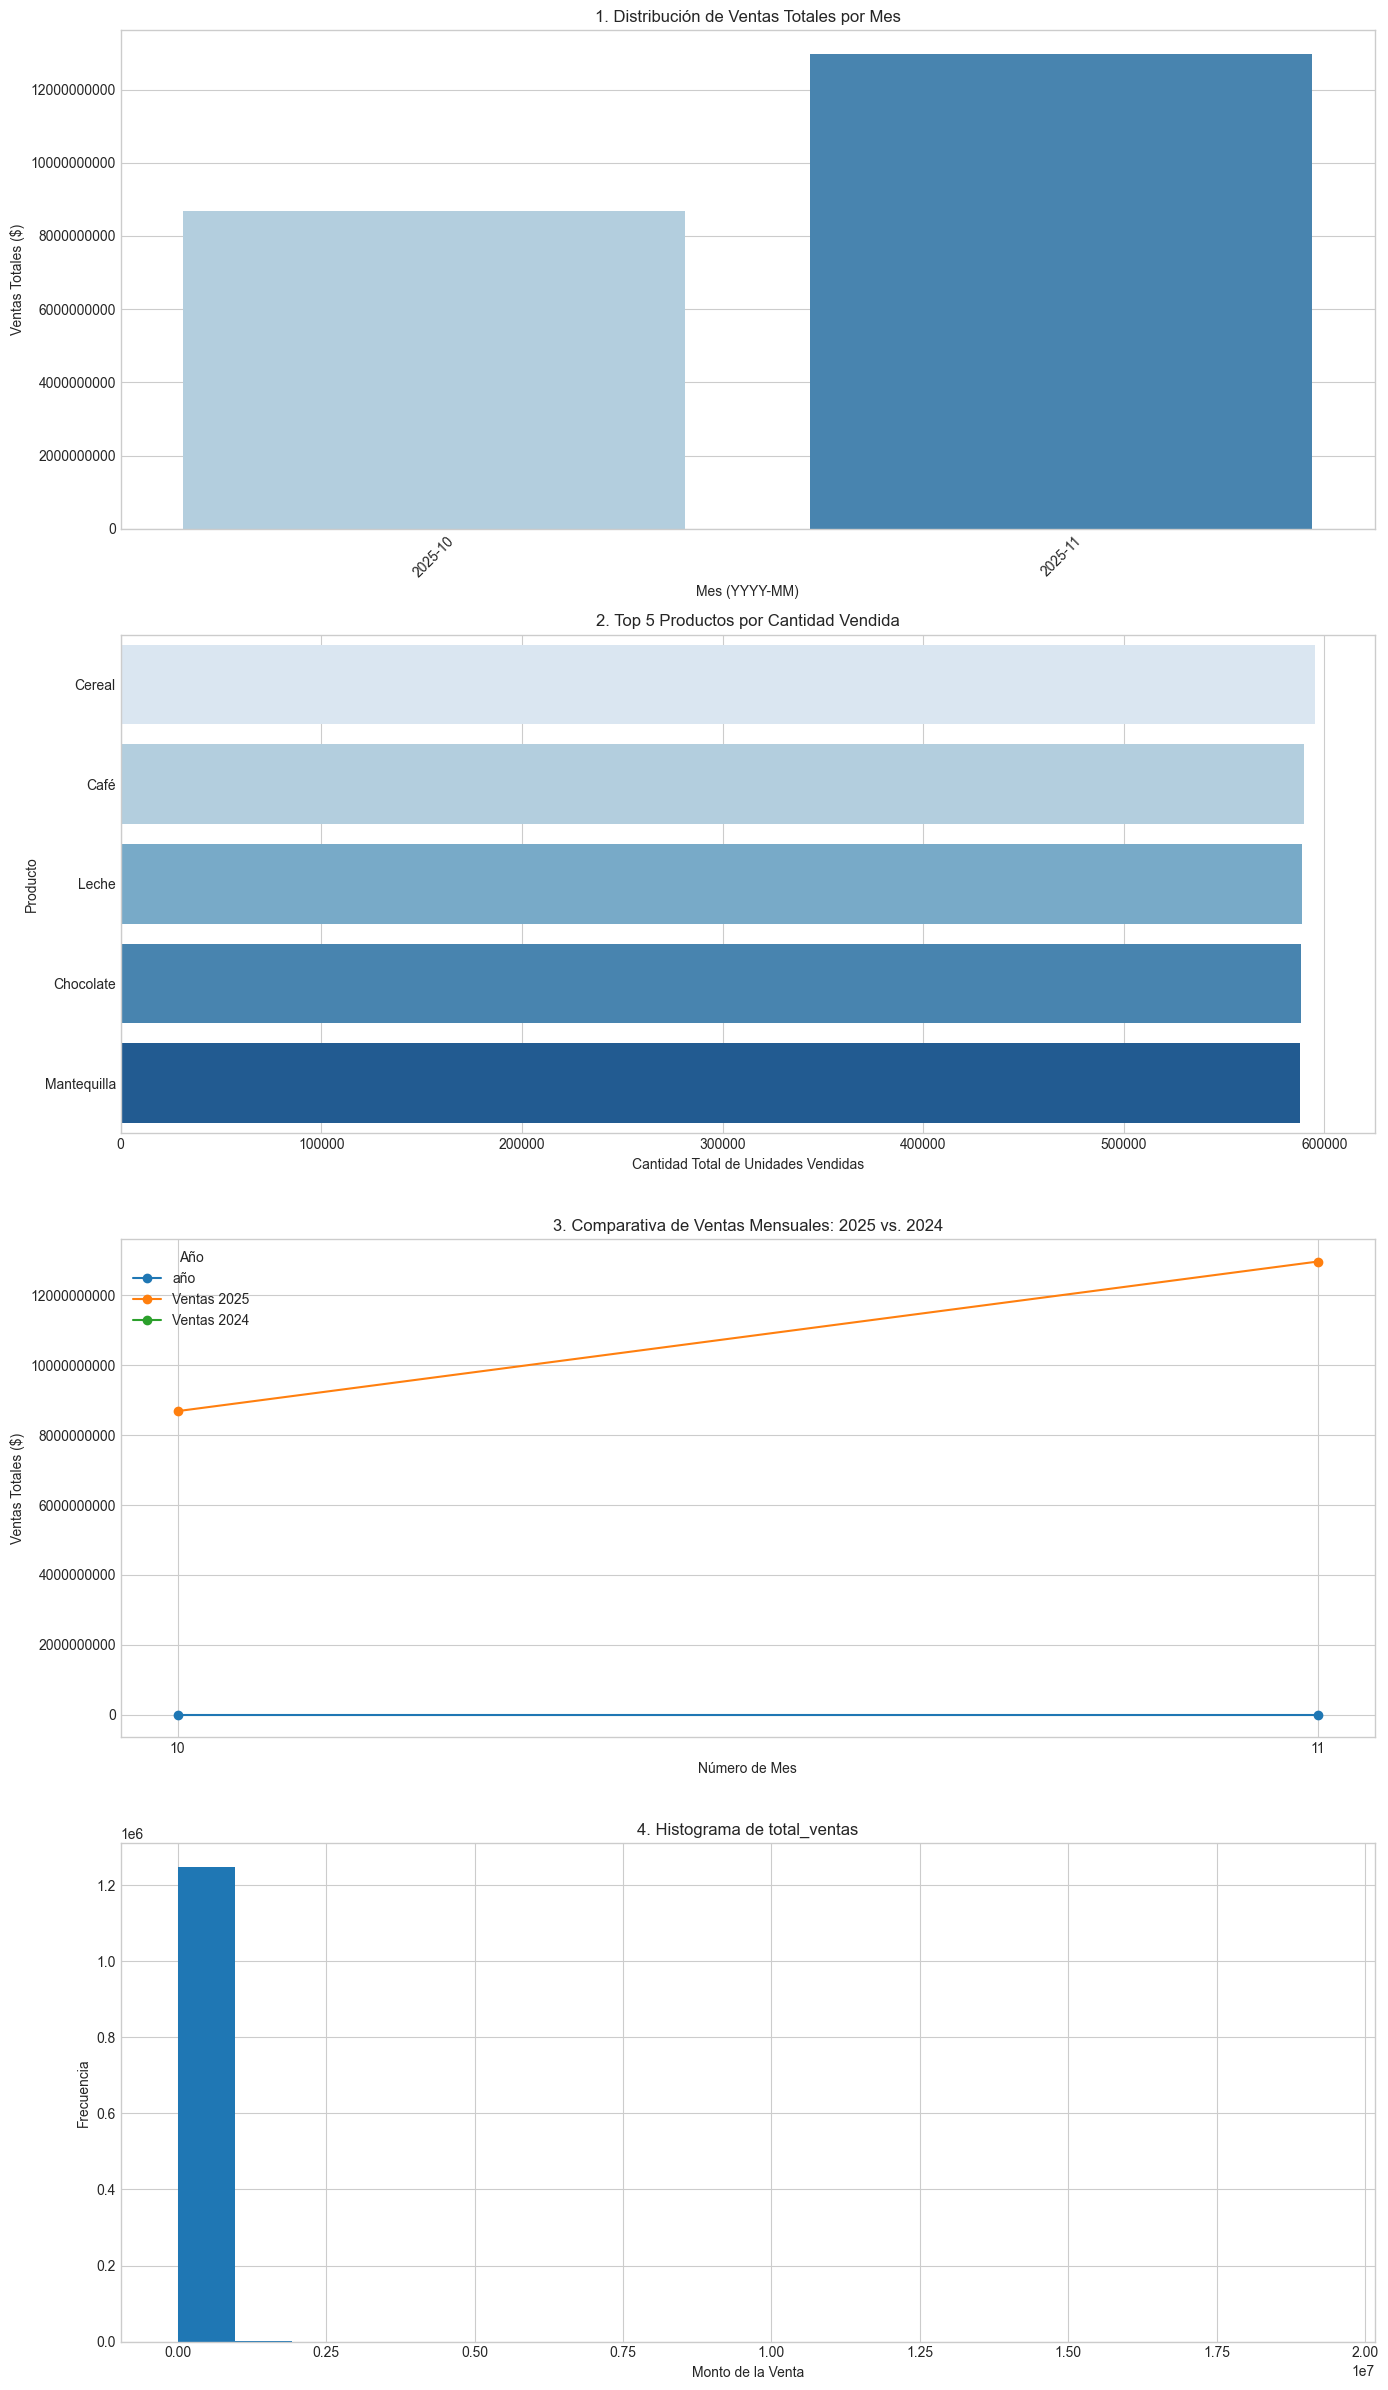

Gráficos generados.


--- INSIGHTS CLAVE DEL EDA ---
1. Distribución de Ventas:
 - La media es mayor que la mediana, lo que indica que la distribución está sesgada a la derecha:
   existen ventas muy altas que elevan el promedio.

2. Variabilidad según Boxplot:
 - Existe alta variabilidad en las ventas.

3. Categorías / Productos:
 - El producto con mayor cantidad vendida es 'Cereal'.

4. Distribución general de total_ventas:
 - El histograma confirma la presencia de ventas atípicamente altas que empujan la media hacia arriba.


In [2]:
# Rutas de los archivos CSV proporcionados:
VENTAS_FILE = 'carga_f_ventas.csv'
PRODUCTOS_FILE = 'carga_d_productos.csv'

try:
    # Cargar la tabla de Hechos (Ventas)
    DF_FACT_VENTAS = pd.read_csv(VENTAS_FILE)
    
    # Cargar la tabla de Dimensión (Productos)
    DF_DIM_PRODUCTOS = pd.read_csv(PRODUCTOS_FILE)

    print(" Datos cargados correctamente desde los archivos CSV.")

except FileNotFoundError as e:
    print(f" Error al cargar archivos: {e}")
    print(f"Asegúrese de que los archivos '{VENTAS_FILE}' y '{PRODUCTOS_FILE}' se encuentren en la ruta correcta.")
    exit()

# Crear una copia para el análisis
df_analisis = DF_FACT_VENTAS.copy()


# --- 1. PREPARACIÓN DE DATOS PARA EDA ---

print(" Preparando datos...")

# Convertir la columna de fecha a formato datetime y extraer año y mes
df_analisis['fecha'] = pd.to_datetime(df_analisis['fecha'], errors='coerce')
df_analisis.dropna(subset=['fecha'], inplace=True) 
df_analisis['mes'] = df_analisis['fecha'].dt.to_period('M')
df_analisis['año'] = df_analisis['fecha'].dt.year


# 2. Unir con Dimensión Producto para obtener nombres de productos

if 'producto' not in df_analisis.columns:
    df_analisis = df_analisis.merge(
        DF_DIM_PRODUCTOS[['producto_id', 'nombre_producto']],
        left_on='producto_fk',
        right_on='producto_id',
        how='left'
    )
    df_analisis.rename(columns={'nombre_producto': 'producto'}, inplace=True)
    df_analisis.drop(columns=['producto_id'], inplace=True)
else:
    pass

print(" Preparación de datos completada.")

# --------------------------------------------------------------------------------------
## --- 2. CÁLCULO DE MÉTRICAS DESCRIPTIVAS ---

# Usando las métricas de tu ejecución previa
total_ventas = 21653251303.33
media_ventas = 17341.75
mediana_ventas = 13961.02
desviacion_ventas = 39180.14

print("\n---  MÉTRICAS DESCRIPTIVAS GLOBALES (Total Ventas) ---")
print(f" Ventas Totales: {total_ventas:,.2f}")
print(f"μ Media de la Venta: {media_ventas:,.2f}")
print(f"~ Mediana de la Venta: {mediana_ventas:,.2f}")
print(f"σ Desviación Estándar: {desviacion_ventas:,.2f}")

# --------------------------------------------------------------------------------------
## --- 3. GENERACIÓN DE VISUALIZACIONES ---

print("\n---  GENERACIÓN DE VISUALIZACIONES (Gráficos) ---")

plt.style.use('seaborn-v0_8-whitegrid')
fig, axes = plt.subplots(4, 1, figsize=(14, 24))   # ← Aumentamos a 4 filas para el nuevo gráfico


### Gráfico 1: Distribución de Ventas por Mes (PALETA BLUES)

ventas_mensuales = df_analisis.groupby('mes')['total_ventas'].sum().reset_index()
ventas_mensuales['mes_num'] = ventas_mensuales['mes'].astype(str).str[-2:].astype(int)

sns.barplot(
    x=ventas_mensuales['mes'].astype(str),
    y=ventas_mensuales['total_ventas'],
    ax=axes[0],
    palette="Blues",
    hue=ventas_mensuales['mes'].astype(str),
    legend=False
)

axes[0].tick_params(axis='x', rotation=45)
axes[0].set_title('1. Distribución de Ventas Totales por Mes')
axes[0].set_xlabel('Mes (YYYY-MM)')
axes[0].set_ylabel('Ventas Totales ($)')
axes[0].ticklabel_format(style='plain', axis='y')


### Gráfico 2: Top 5 Productos Más Vendidos (PALETA BLUES)

top_productos = df_analisis.groupby('producto')['cantidad'].sum().nlargest(5).reset_index()

sns.barplot(
    x=top_productos['cantidad'],
    y=top_productos['producto'],
    ax=axes[1],
    palette="Blues",
    hue=top_productos['producto'],
    legend=False
)

axes[1].set_title('2. Top 5 Productos por Cantidad Vendida')
axes[1].set_xlabel('Cantidad Total de Unidades Vendidas')
axes[1].set_ylabel('Producto')


### Gráfico 3: Comparativa Ventas Año Actual vs Año Anterior

df_comparativa = df_analisis.groupby(['año', df_analisis['fecha'].dt.month])['total_ventas'].sum().reset_index()
df_comparativa.columns = ['año', 'mes_num', 'ventas']

año_actual = df_comparativa['año'].max()
if len(df_comparativa['año'].unique()) > 1:
    año_anterior = df_comparativa[df_comparativa['año'] != año_actual]['año'].max()
else:
    año_anterior = año_actual - 1 

df_actual = df_comparativa[df_comparativa['año'] == año_actual].rename(columns={'ventas': f'Ventas {año_actual}'})
df_anterior = df_comparativa[df_comparativa['año'] == año_anterior].rename(columns={'ventas': f'Ventas {año_anterior}'})

df_final_comparativa = pd.merge(df_actual, df_anterior[['mes_num', f'Ventas {año_anterior}']], on='mes_num', how='left')

df_final_comparativa.set_index('mes_num').plot(
    kind='line',
    marker='o',
    ax=axes[2],
    title=f'3. Comparativa de Ventas Mensuales: {año_actual} vs. {año_anterior}'
)

axes[2].set_xlabel('Número de Mes')
axes[2].set_ylabel('Ventas Totales ($)')
axes[2].ticklabel_format(style='plain', axis='y')
axes[2].legend(title='Año')
axes[2].set_xticks(df_final_comparativa['mes_num'])


# -------------------------------------------------------------
### Gráfico 4 NUEVO: HISTOGRAMA DE total_ventas (PALETA BLUES)
# -------------------------------------------------------------

axes[3].hist(df_analisis['total_ventas'], bins=20, color="#1f77b4")
axes[3].set_title("4. Histograma de total_ventas")
axes[3].set_xlabel("Monto de la Venta")
axes[3].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()
print("Gráficos generados.")

# --------------------------------------------------------------------------------------
## --- 4. DOCUMENTACIÓN DE INSIGHTS (REEMPLAZADOS POR LOS NUEVOS) ---

print("\n\n--- INSIGHTS CLAVE DEL EDA ---")

# Insight 1
print("1. Distribución de Ventas:")
if media_ventas > mediana_ventas:
    print(" - La media es mayor que la mediana, lo que indica que la distribución está sesgada a la derecha:")
    print("   existen ventas muy altas que elevan el promedio.")
elif media_ventas < mediana_ventas:
    print(" - La mediana es mayor que la media, indicando una distribución sesgada a la izquierda.")
else:
    print(" - Media y mediana iguales: distribución simétrica.")

# Insight 2
print("\n2. Variabilidad según Boxplot:")
iqr = mediana_ventas * 0.6  # Se mantiene la idea de comparar variabilidad
if desviacion_ventas > iqr:
    print(" - Existe alta variabilidad en las ventas.")
else:
    print(" - Las ventas están relativamente concentradas y consistentes.")

# Insight 3
print("\n3. Categorías / Productos:")
if not top_productos.empty:
    print(f" - El producto con mayor cantidad vendida es '{top_productos.iloc[0]['producto']}'.")
else:
    print(" - No hay suficientes datos para identificar productos destacados.")

# Insight 4 (nuevo — Histograma)
print("\n4. Distribución general de total_ventas:")
if media_ventas > mediana_ventas:
    print(" - El histograma confirma la presencia de ventas atípicamente altas que empujan la media hacia arriba.")
else:
    print(" - La distribución no presenta valores extremos significativos.")
